In [9]:
%matplotlib inline
import pymc as pm

Text(0.5,1,'Probability mass function - Z~Poi(Lambda)')

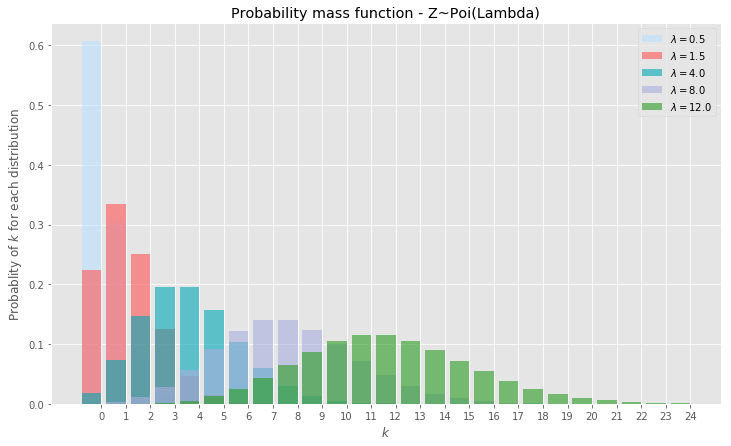

In [26]:
# Lambda is the parameter of the distribution and it controls the distributions shape

import scipy.stats as stats
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
matplotlib.style.use('ggplot')

a = np.arange(25)
poi = stats.poisson
lambda_ = [.5, 1.5, 4, 8, 12]
alpha_num =  .6
colours = ["#BAE0FF", "#FF5555", "#00A8B3", "#AAAFDF", "#299C21"]

plt.rcParams['figure.figsize'] = [12, 7]
plt.bar(a, poi.pmf(a, lambda_[0]), color=colours[0], label="$\lambda = %.1f$" % lambda_[0], alpha=alpha_num, lw="2")
plt.bar(a, poi.pmf(a, lambda_[1]), color=colours[1], label="$\lambda = %.1f$" % lambda_[1], alpha=alpha_num, lw="2")
plt.bar(a, poi.pmf(a, lambda_[2]), color=colours[2], label="$\lambda = %.1f$" % lambda_[2], alpha=alpha_num, lw="2")
plt.bar(a, poi.pmf(a, lambda_[3]), color=colours[3], label="$\lambda = %.1f$" % lambda_[3], alpha=alpha_num, lw="2")
plt.bar(a, poi.pmf(a, lambda_[4]), color=colours[4], label="$\lambda = %.1f$" % lambda_[4], alpha=alpha_num, lw="2")

plt.xticks(a + .4, a)
plt.legend()
plt.ylabel("Probablity of $k$ for each distribution")
plt.xlabel("$k$")
plt.title("Probability mass function - Z~Poi(Lambda)")

In [49]:
# Let's assume Z is discrete, so we're looking at a probability MASS funciton. If this 
# was a continuous variable we would be looking at a probability DENSITY funciton

# Notice how as we inrease the lambda the poisson distributino becomes more normal
# We're modeling the COUNTS of events 

Text(0.5,1,'Probability density function - Z~Exp(Lambda)')

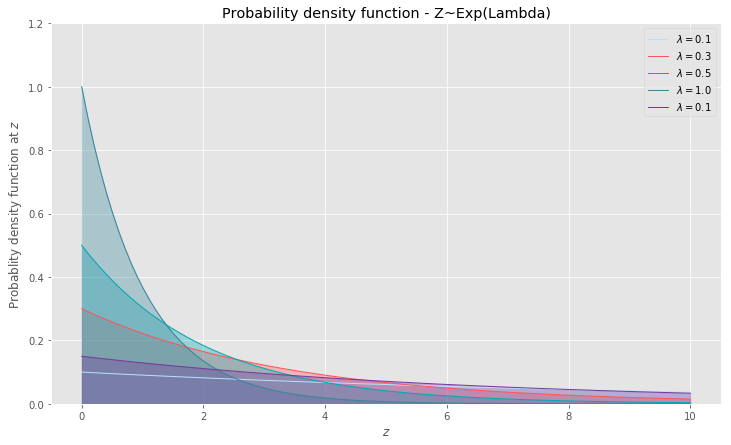

In [50]:
# What about a CONTINUOUS case ... so we're looking at a probabilty DENSITY function
# from a exopnential distrubiton

a = np.linspace(0, 10, 100)
expo = stats.expon
lambda_ = [.1, .3, .5, 1, .15]
colours = ["#BAE0FF", "#FF5555", "#00A8B3", "#37869D", "#78379D"]
plt.rcParams['figure.figsize'] = [12, 7]

# plt.plot(a, expo.pdf(a, scale=1./1), lw=3, color=colours[0], label="$\lambda = %.1f$" % lambda_[0])
# plt.fill_between(a, expo.pdf(a, scale=1./1), color=colours[0], alpha=.33)

# plt.plot(a, expo.pdf(a, scale=1./1), lw=3, color=colours[3], label="$\lambda = %.1f$" % lambda_[3])
# plt.fill_between(a, expo.pdf(a, scale=1./1), color=colours[3], alpha=.33)

for c, l in zip(colours, lambda_): 
    plt.plot(a, expo.pdf(a, scale=1./l), lw=1, color=c, label="$\lambda = %.1f$" % l)
    plt.fill_between(a, expo.pdf(a, scale=1./l), color=c, alpha=.33)

plt.legend()
plt.ylim(0, 1.2)
plt.ylabel("Probablity density function at $z$")
plt.xlabel("$z$")
plt.title("Probability density function - Z~Exp(Lambda)")

In [51]:
# In the real world we only see Z and work our way backwards to find lambda 
# ... because lambda (the mean) is never actually observed

# Bayesian is looking at what we think lambda can be ... what it is most likey to be

In [2]:
# The main dataset to look at
import pandas as pd
df = pd.read_csv('traffic3.csv')

In [3]:
df.head()

,date,count
0,01-01-2016,19
1,08-01-2016,33
2,10-01-2016,16
3,17-01-2016,31
4,26-01-2016,14


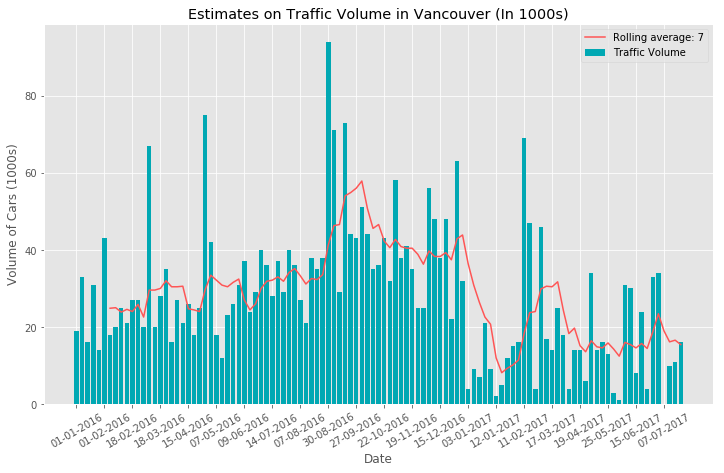

In [87]:
n = len(df)
ticks_to_use = df.date[::5] # Every 20th date
labels = [ i.strip("%Y-%m-%d") for i in ticks_to_use ]
plt.rcParams['figure.figsize'] = [12, 7]
window = 7
rolling_mean = df['count'].rolling(window = window, center=False).mean()

plt.bar(df['date'], df['count'], color=colours[2], label="Traffic Volume") 
plt.xticks(ticks_to_use, labels, rotation=30)
plt.ylabel("Volume of Cars (1000s)")
plt.xlabel("Date")
plt.title("Estimates on Traffic Volume in Vancouver (In 1000s)")
plt.plot(rolling_mean, color=colours[1], label="Rolling average: %i" % window)
plt.legend(loc="upper right")

In [96]:
import pymc as pm

alpha = 1.0 / df['count'].mean()  

lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper=n)
# print "Random output:", tau.random(), tau.random(), tau.random()

@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):

    out = np.zeros(n)
    out[:tau] = lambda_1  # lambda before tau is lambda1
    out[tau:] = lambda_2  # lambda after (and including) tau is lambda2
    return out

observation = pm.Poisson("obs", lambda_, value=df['count'], observed=True)
model = pm.Model([observation, lambda_1, lambda_2, tau])

In [97]:
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000)

 [-----------------100%-----------------] 40000 of 40000 complete in 6.5 sec

In [98]:
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

(63, 72)

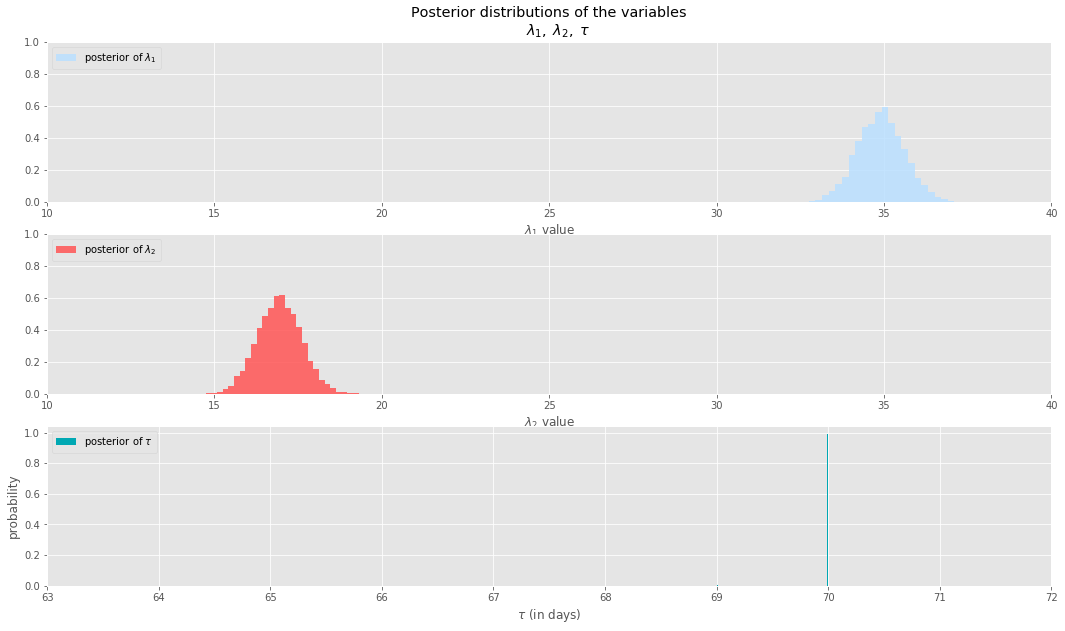

In [99]:
plt.figure(figsize=(18, 10))
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

# Graph one
plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color=colours[0], normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlabel("$\lambda_1$ value")
plt.xlim([10,40])

# Graph two
ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color=colours[1], normed=True)
plt.legend(loc="upper left")
plt.xlabel("$\lambda_2$ value")
plt.xlim([10,40])

# Graph three
plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=len(df), alpha=1,
         label=r"posterior of $\tau$",
         color=colours[2], weights=w, rwidth=5)
plt.xticks(np.arange(0, len(df)))
plt.legend(loc="upper left")
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");
plt.xlim([63,72])

In [100]:
np.unique(tau_samples, return_counts=True)

(array([69, 70]), array([  200, 29800]))

In [101]:
# Plausable values for lambda 1 and 2 are 35 and 17

# And tau is giving us a 100% probability the behaviour changed here
# Had no change occured the posterior would have been more spread out

# Now that we know lambda - which is the expected value - we can start to estimate
# what a value will be at a certin time

# In numpy/pandas, it is used for elementwise comparison of arrays. For example, 
# if arr = [True, False, True], ~arr returns [False, True, False]

# ~ is the bitwise complement operator in python which essentially calculates -x - 1

N = tau_samples.shape[0]

expected_traffic = np.zeros(len(df))
for day in range (0, len(df)):
    ix = day < tau_samples
    expected_traffic[day] = (lambda_1_samples[ix].sum() + lambda_2_samples[~ix].sum()) / N

Text(0.5,1,'Estimates on Traffic Volume (In 1000s) in Vancouver since 01-01-2016')

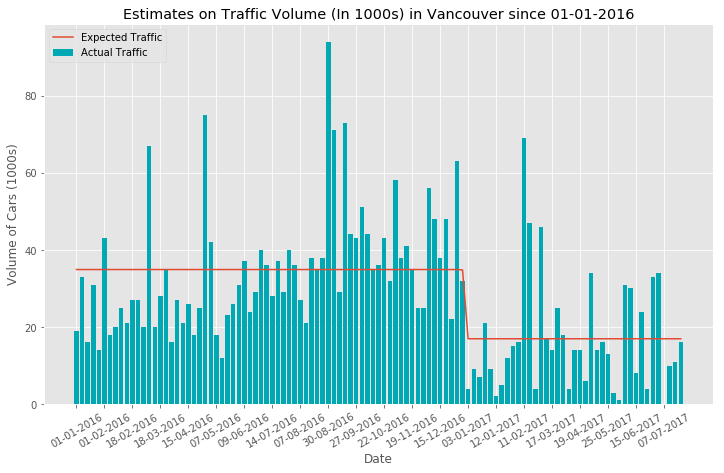

In [102]:
plt.plot(range(n), expected_traffic, label='Expected Traffic')
plt.bar(df['date'], df['count'], color="#00A8B3", label='Actual Traffic') 
plt.legend(loc="upper left")
plt.xticks(ticks_to_use, labels, rotation=30)
plt.ylabel("Volume of Cars (1000s)")
plt.xlabel("Date")
plt.title("Estimates on Traffic Volume (In 1000s) in Vancouver since %s" % df['date'][0])

In [64]:
# Looks like there has been a massive shift at period 70 ... and there should be
# Our analysis shows string support for a user's behaviour changing at that period
# If wer did not see that the lambdas would be quite similar ... and the change was
# quite sudden ... what could have caused this?

In [103]:
print (lambda_1_samples > lambda_2_samples).mean()

1.0


In [104]:
# We are 100% confident the values are quite different because all of lambda_1
# are larger than lambda_2

for d in [1, 2, 5, 10, 13, 15, 16, 17, 28, 19, 20]:
    v = (abs(lambda_1_samples - lambda_2_samples) >= d).mean()
    print "What is the probability the difference is larger than %d? %.2f" % (d, v)

What is the probability the difference is larger than 1? 1.00
What is the probability the difference is larger than 2? 1.00
What is the probability the difference is larger than 5? 1.00
What is the probability the difference is larger than 10? 1.00
What is the probability the difference is larger than 13? 1.00
What is the probability the difference is larger than 15? 1.00
What is the probability the difference is larger than 16? 0.98
What is the probability the difference is larger than 17? 0.84
What is the probability the difference is larger than 28? 0.00
What is the probability the difference is larger than 19? 0.14
What is the probability the difference is larger than 20? 0.02


In [111]:
# What about TWO switch points
# Let's model this again

import pymc as pm

alpha = 1.0 / df['count'].mean()  # Recall count_data is the

n_minus_one = (n - 1)

lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)
lambda_3 = pm.Exponential("lambda_3", alpha)

tau_1 = pm.DiscreteUniform("tau_1", lower=0, upper=n_minus_one)
tau_2 = pm.DiscreteUniform("tau_2", lower=tau_1, upper= n)

In [112]:
@pm.deterministic
def lambda_(tau_1=tau_1, tau_2=tau_2, lambda_1=lambda_1, lambda_2=lambda_2, lambda_3=lambda_3):

    out = np.zeros(n)
    out[:tau_1] = lambda_1  # lambda before tau is lambda1
    out[tau_1:tau_2] = lambda_2  # lambda before tau is lambda1
    out[tau_2:] = lambda_3  # lambda after (and including) tau is lambda2
    return out

observation = pm.Poisson("obs", lambda_, value=df['count'], observed=True)
model = pm.Model([observation, lambda_1, lambda_2, lambda_3, tau_1, tau_2])

In [113]:
# Mysterious code to be explained in Chapter 3.
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000)
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
lambda_3_samples = mcmc.trace('lambda_3')[:]
tau_1_samples = mcmc.trace('tau_1')[:]
tau_2_samples = mcmc.trace('tau_2')[:]

 [-----------------100%-----------------] 40000 of 40000 complete in 11.8 sec

(65, 72)

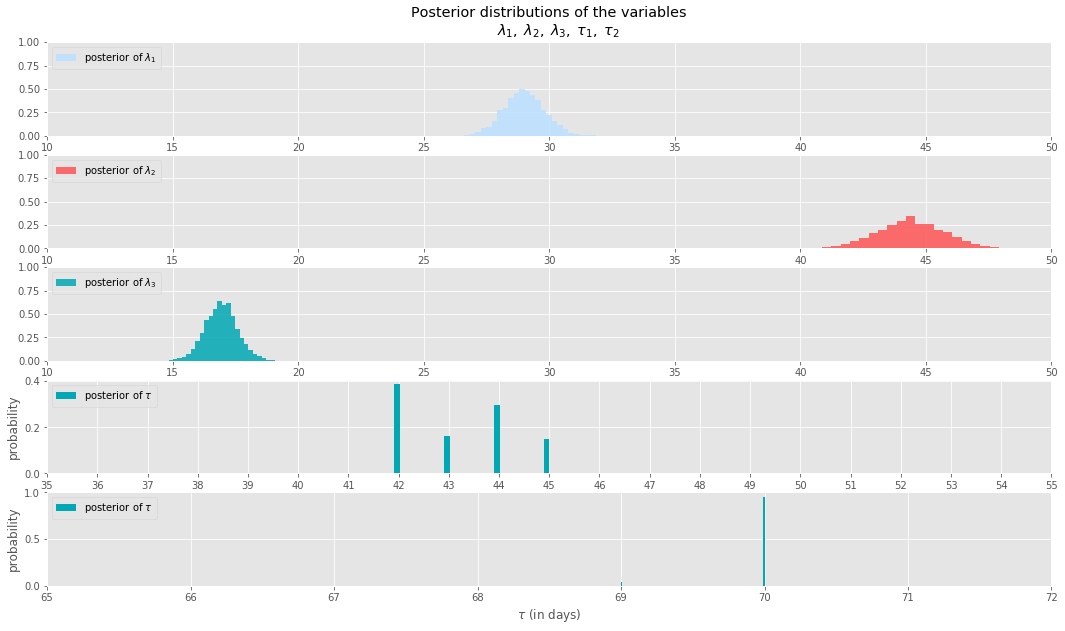

In [114]:
plt.figure(figsize=(18, 10))
ax = plt.subplot(511)
ax.set_autoscaley_on(False)

# Plot 1
plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color=colours[0], normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\lambda_3,\;\tau_1,\;\tau_2$""")
plt.xlabel("$\lambda_1$ value")
plt.xlim([10, 50])

# Plot 2
ax = plt.subplot(512)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color=colours[1], normed=True)
plt.legend(loc="upper left")
plt.xlabel("$\lambda_2$ value")
plt.xlim([10, 50])

# Plot 3
ax = plt.subplot(513)
ax.set_autoscaley_on(False)
plt.hist(lambda_3_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_3$", color=colours[2], normed=True)
plt.legend(loc="upper left")
plt.xlabel("$\lambda_2$ value")
plt.xlim([10, 50])

# Plot 4
plt.subplot(514)
w = 1.0 / tau_1_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_1_samples, bins=len(df), alpha=1,
         label=r"posterior of $\tau$",
         color=colours[2], weights=w, rwidth=5)
plt.xticks(np.arange(0, len(df)))
plt.legend(loc="upper left")
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");
plt.xlim([35, 55])

# Plot 5
plt.subplot(515)
w = 1.0 / tau_2_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_2_samples, bins=len(df), alpha=1,
         label=r"posterior of $\tau$",
         color=colours[2], weights=w, rwidth=5)
plt.xticks(np.arange(0, len(df)))
plt.legend(loc="upper left")
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");
plt.xlim([65, 72])

In [115]:
unique_elements, counts_elements = np.unique(tau_1_samples, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[   33    34    35    36    38    39    41    42    43    44    45]
 [    4     1     1     3    12     5    36 11638  4894  8895  4511]]


In [116]:
sum_counts = counts_elements.sum()

In [117]:
unique_elements, counts_elements = np.unique(tau_2_samples, return_counts=True)
percent_of_count = np.zeros(len(counts_elements))
count = 0

# for i in counts_elements:
#     percent_of_count[count] = round((i / sum_counts) * 100.00 , 2)
#     count += 1

print "Frequency of unique values of the said array:"
print np.asarray((unique_elements, counts_elements))
# print percent_of_count

Frequency of unique values of the said array:
[[   69    70]
 [ 1342 28658]]


In [118]:
# Looks correct given the switch points I put into the data  ... + 20 starts at n = 32

# is is a bool index of all the tau samples coresponding to the switch point occuring prior \
# to the value of the day

# Each posterior sample corresponds to a value of tau indeicates wether we're before
# (n lambda_1) or after (in lambda_2)

# By taking the posterior sample of the lambda 1 and 2 we can average over all
# samples to get an expected value for lambda on that day

# Because the count is a poisson distribution the lambda is the expected value

N_1 = tau_1_samples.shape[0]
N_2 = tau_2_samples.shape[0]

expected_traffic_2 = np.zeros(len(df))

for day in range (0, len(df)):
    
    # For the first period
    if day < max(tau_1_samples):
        ix = day < tau_1_samples
        expected_traffic_2[day] = (lambda_1_samples[ix].sum() + lambda_2_samples[~ix].sum()) / N_1
    
    # For the second period
    else:
        ix = day < tau_2_samples
        expected_traffic_2[day] = (lambda_2_samples[ix].sum() + lambda_3_samples[~ix].sum()) / N_2

Text(0.5,1,'Estimates on Traffic Volume (In 1000s) in Vancouver over 109 days')

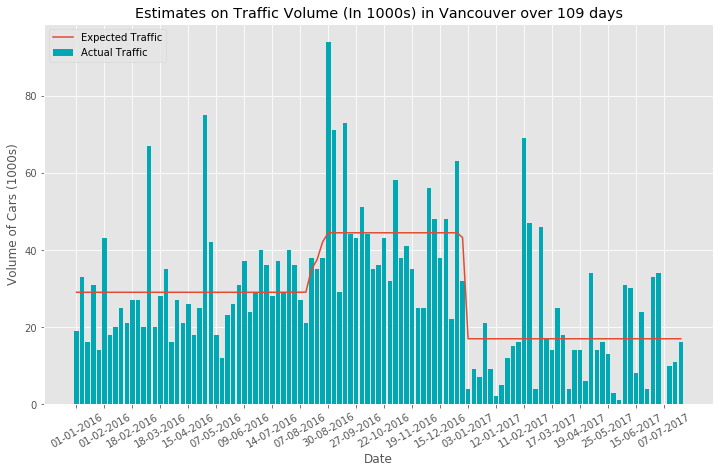

In [119]:
plt.plot(range(n), expected_traffic_2, label='Expected Traffic')
plt.bar(df['date'], df['count'], color="#00A8B3", label='Actual Traffic') 
plt.legend(loc="upper left")
plt.xticks(ticks_to_use, labels, rotation=30)
plt.ylabel("Volume of Cars (1000s)")
plt.xlabel("Date")
plt.title("Estimates on Traffic Volume (In 1000s) in Vancouver over %s days" % n)

In [120]:
for d in [1, 2, 5, 10, 13, 15, 16, 17, 18, 19, 20]:
    v = (abs(lambda_1_samples - lambda_2_samples) >= d).mean()
    print "What is the probability the difference is larger than %d? %.2f" % (d, v)

What is the probability the difference is larger than 1? 1.00
What is the probability the difference is larger than 2? 1.00
What is the probability the difference is larger than 5? 1.00
What is the probability the difference is larger than 10? 1.00
What is the probability the difference is larger than 13? 0.95
What is the probability the difference is larger than 15? 0.60
What is the probability the difference is larger than 16? 0.35
What is the probability the difference is larger than 17? 0.15
What is the probability the difference is larger than 18? 0.05
What is the probability the difference is larger than 19? 0.01
What is the probability the difference is larger than 20? 0.00


In [121]:
for d in [1, 2, 5, 10, 13, 15, 16, 17, 18, 19, 20, 21, 25, 26, 27, 28, 29, 30]:
    v = (abs(lambda_2_samples - lambda_3_samples) >= d).mean()
    print "What is the probability the difference is larger than %d? %.2f" % (d, v)

What is the probability the difference is larger than 1? 1.00
What is the probability the difference is larger than 2? 1.00
What is the probability the difference is larger than 5? 1.00
What is the probability the difference is larger than 10? 1.00
What is the probability the difference is larger than 13? 1.00
What is the probability the difference is larger than 15? 1.00
What is the probability the difference is larger than 16? 1.00
What is the probability the difference is larger than 17? 1.00
What is the probability the difference is larger than 18? 1.00
What is the probability the difference is larger than 19? 1.00
What is the probability the difference is larger than 20? 1.00
What is the probability the difference is larger than 21? 1.00
What is the probability the difference is larger than 25? 0.95
What is the probability the difference is larger than 26? 0.84
What is the probability the difference is larger than 27? 0.63
What is the probability the difference is larger than 28? 

In [122]:
l1_l2_change = (lambda_2_samples - lambda_1_samples ) / lambda_1_samples
l2_l3_change = (lambda_3_samples - lambda_2_samples ) / lambda_2_samples

Text(0.5,1,'Posterior Change Between tau1 and tau2')

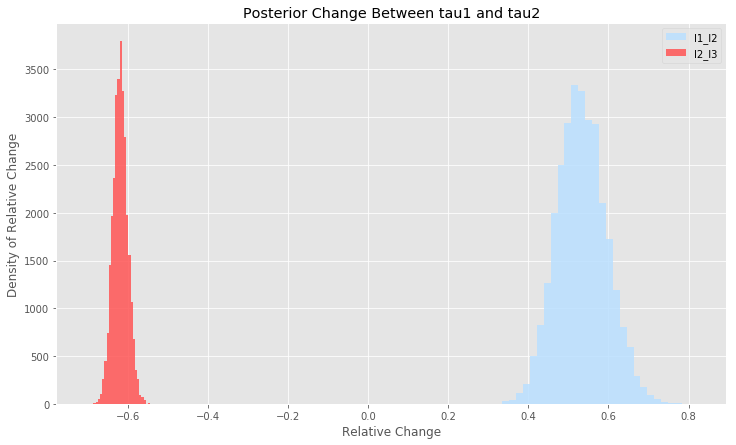

In [123]:
plt.hist(l1_l2_change, histtype='stepfilled', bins=30, alpha=0.85, color = colours[0], label='l1_l2')
plt.hist(l2_l3_change, histtype='stepfilled', bins=30, alpha=0.85, color = colours[1], label='l2_l3')
plt.legend(loc="upper right")
plt.ylabel("Density of Relative Change")
plt.xlabel("Relative Change")
plt.title("Posterior Change Between tau1 and tau2")